<a href="https://colab.research.google.com/github/rummanrc/bhcr95_thesis/blob/master/BHCR_Final95git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1VDhREH641kggWWzWr_PLmnFEBidGQaLE'})
download.GetContentFile('images.zip')


In [0]:
!unzip images.zip

Found 88014 images belonging to 50 classes.
Found 9756 images belonging to 50 classes.
Epoch 1/70
781/781 [==============================] - 106s 135ms/step - loss: 3.8708 - acc: 0.0364 - val_loss: 3.3414 - val_acc: 0.2620

Epoch 00001: val_acc improved from -inf to 0.26199, saving model to Aug97k100epo.h5
Epoch 2/70
781/781 [==============================] - 103s 132ms/step - loss: 2.7616 - acc: 0.2634 - val_loss: 1.7070 - val_acc: 0.5361

Epoch 00002: val_acc improved from 0.26199 to 0.53608, saving model to Aug97k100epo.h5
Epoch 3/70
781/781 [==============================] - 103s 132ms/step - loss: 2.0989 - acc: 0.4190 - val_loss: 1.2149 - val_acc: 0.6602

Epoch 00003: val_acc improved from 0.53608 to 0.66021, saving model to Aug97k100epo.h5
Epoch 4/70
781/781 [==============================] - 103s 132ms/step - loss: 1.7007 - acc: 0.5153 - val_loss: 0.8844 - val_acc: 0.7478

Epoch 00004: val_acc improved from 0.66021 to 0.74785, saving model to Aug97k100epo.h5
Epoch 5/70
781/781 [

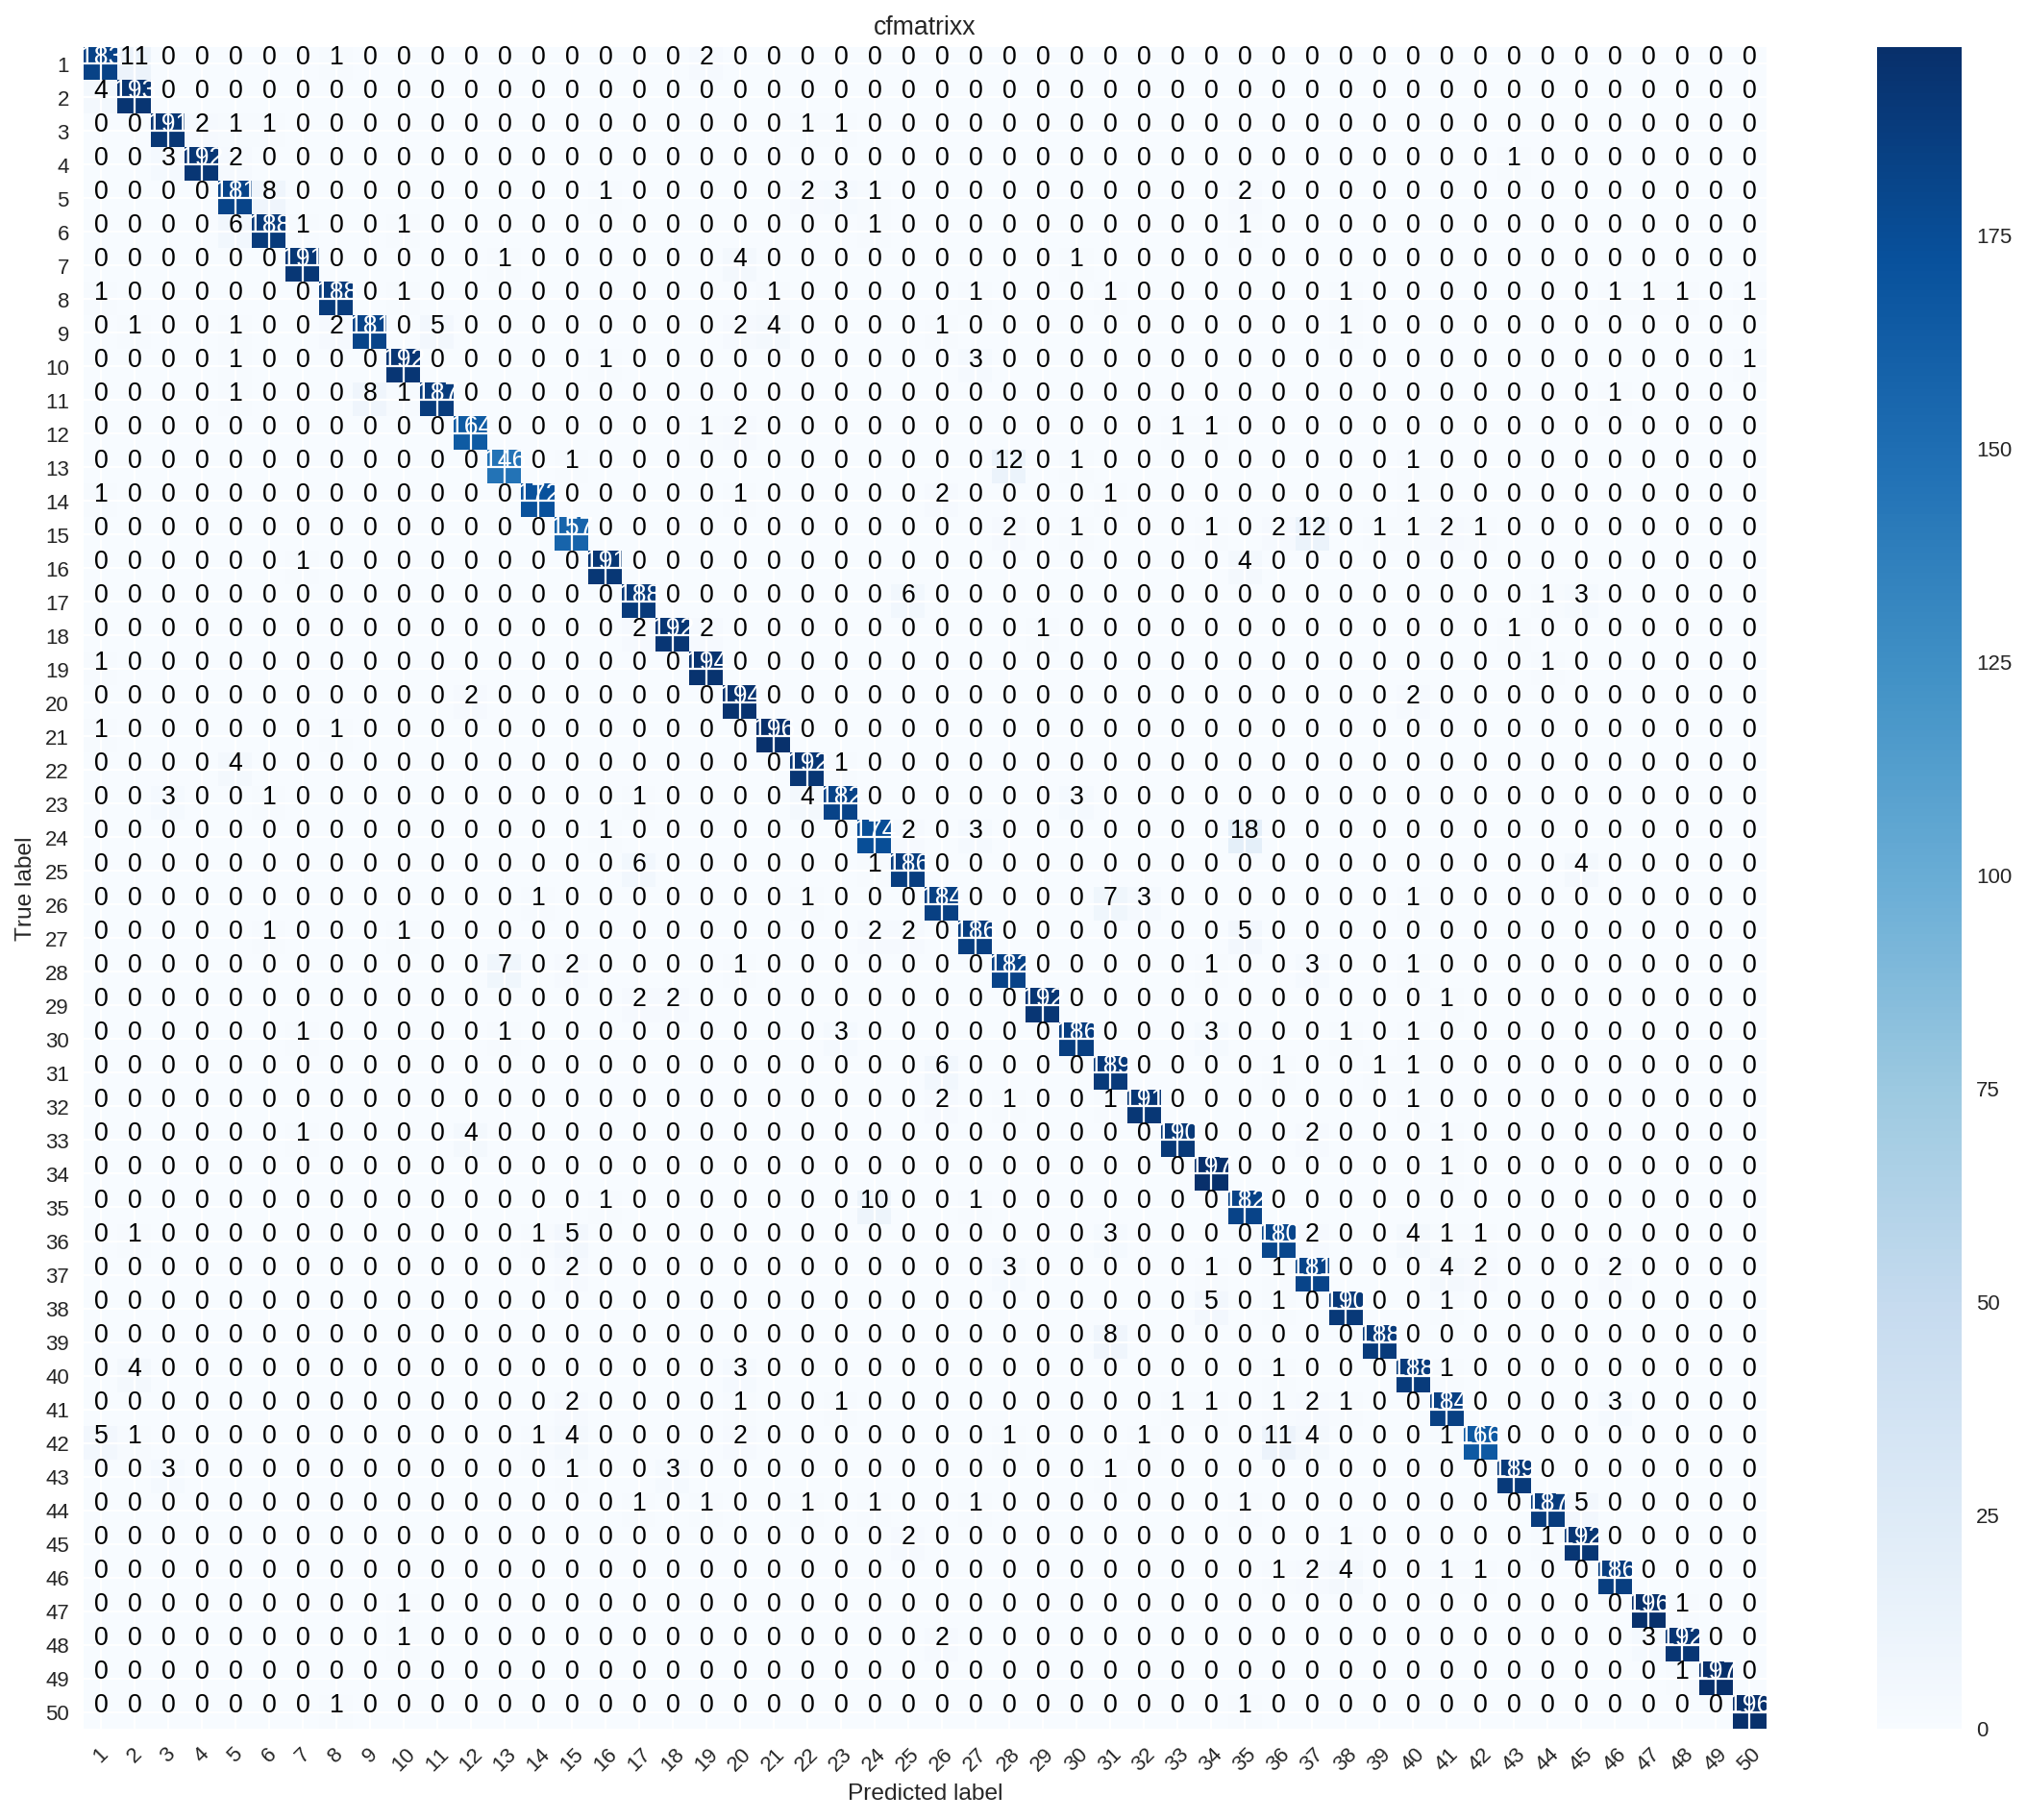

In [0]:
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
import numpy as np
import PIL
from PIL import Image
from keras import optimizers
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Model
from keras import applications
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
'''
mobile=applications.mobilenet.MobileNet()
#mobile.summary()
x=mobile.layers[-6].output
predictions=Dense(50,activation='softmax')(x)
model=Model(inputs=mobile.input, outputs=predictions)
#model.summary()

for layer in model.layers[:-5]:
    layer.trainable=False

model.compile(optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
'''
classifier = Sequential()

# Step 1 - Convolution

classifier.add(Conv2D(32, (5, 5), activation='relu', input_shape=(50, 50, 1)))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (5, 5), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#classifier.add(Dropout(0.25))
# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units=1024,activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=1024,activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=512,activation='relu'))
classifier.add(Dense(units=50, activation='softmax'))
#sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
# Compiling the CNN
sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
classifier.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   validation_split=0.1
                                   #preprocessing_function=applications.mobilenet.preprocess_input
                                   )


training_set = train_datagen.flow_from_directory('Images',
                                                 color_mode='grayscale',
                                                 target_size=(50, 50),
                                                 batch_size=256,
                                                 subset="training",
                                                 class_mode='categorical')

test_set = train_datagen.flow_from_directory('Images',
                                            color_mode='grayscale',
                                            target_size=(50, 50),
                                            batch_size=256,
                                            subset="validation",
                                            class_mode='categorical')

earlyStopping = EarlyStopping(monitor='val_acc', patience=8, verbose=1, mode='max')
mcp_save = ModelCheckpoint('Aug97k100epo.h5', save_best_only=True, verbose=1, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
#NAME = "banglachars-{}".format(int(time.time()))
tb = TensorBoard(log_dir='./logss')
#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history1=classifier.fit_generator(training_set,
                         steps_per_epoch=200000 // 256,
                         epochs=70,
                         validation_data=test_set,
                         validation_steps=20000 // 256,
                         callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tb])
predict_data=ImageDataGenerator(rescale=1. / 255, validation_split=0.1 
            ).flow_from_directory('Images',
                                            color_mode='grayscale',
                                            target_size=(50, 50),
                                            shuffle=False,
                                            batch_size=256,
                                            subset="validation",
                                            class_mode=None)
preds = classifier.predict_generator(predict_data, 9756//256+1)
#preds = model.predict_generator(test_set, 1800//64+1)
#print(preds)
from sklearn.metrics import accuracy_score
print(accuracy_score(predict_data.classes, np.argmax(preds, axis=1)))

cm = confusion_matrix(predict_data.classes, np.argmax(preds, axis=1))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(1, figsize=(15, 12), dpi=160)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ['1', '2','3','4', '5','6','7', '8','9','10', '11','12','13', '14','15','16', '17','18','19', '20','21','22', '23','24','25', '26','27','28', '29','30','31', '32','33','34', '35','36','37', '38','39','40', '41','42','43', '44','45','46', '47','48','49','50']


plot_confusion_matrix(cm, cm_plot_labels, title='cfmatrixx')

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predict_data.classes, np.argmax(preds, axis=1)))

0.9518245182451824


In [0]:
from sklearn.metrics import classification_report
print(classification_report(predict_data.classes, np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       197
           1       0.91      0.98      0.95       197
           2       0.95      0.97      0.96       197
           3       0.99      0.97      0.98       198
           4       0.92      0.91      0.92       198
           5       0.94      0.95      0.95       198
           6       0.98      0.97      0.97       197
           7       0.97      0.95      0.96       198
           8       0.96      0.91      0.94       198
           9       0.97      0.97      0.97       198
          10       0.97      0.94      0.96       198
          11       0.96      0.97      0.97       169
          12       0.94      0.91      0.92       161
          13       0.98      0.97      0.97       178
          14       0.90      0.87      0.89       180
          15       0.98      0.97      0.98       196
          16       0.94      0.95      0.94       198
          17       0.97    

In [0]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2655232   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
__________